# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [32]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
      bird      plane        car        cat


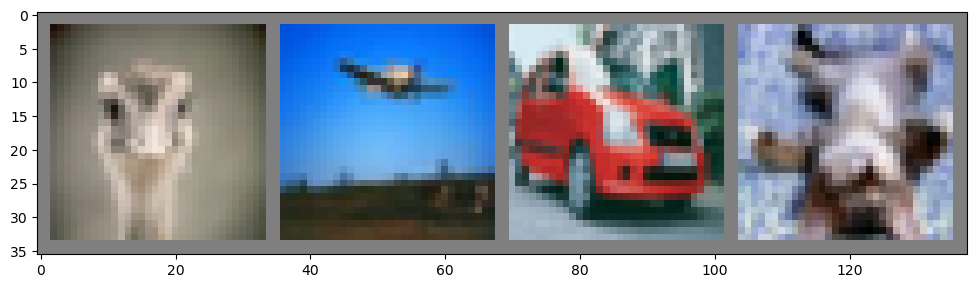

In [33]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
      # Apply convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Flatten for fully connected layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Apply fully connected layers
        x = self.fc(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
# Initialize with higher learning rate and different weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Using cpu device
Epoch 1/10
------------------------------------------------------------
[1,   100] loss: 2.081
[1,   200] loss: 1.611
[1,   300] loss: 1.642
[1,   400] loss: 1.475
[1,   500] loss: 1.696
[1,   600] loss: 1.627
[1,   700] loss: 1.306

Epoch 1 Summary:
Training Loss: 1.646, Training Acc: 39.30%
Val Loss: 1.269, Val Acc: 54.62%
Epoch 2/10
------------------------------------------------------------
[2,   100] loss: 1.492
[2,   200] loss: 1.276
[2,   300] loss: 1.266
[2,   400] loss: 1.268
[2,   500] loss: 1.205
[2,   600] loss: 1.136
[2,   700] loss: 1.215

Epoch 2 Summary:
Training Loss: 1.310, Training Acc: 52.43%
Val Loss: 1.125, Val Acc: 59.69%
Epoch 3/10
------------------------------------------------------------
[3,   100] loss: 1.124
[3,   200] loss: 1.001
[3,   300] loss: 0.983
[3,   400] loss: 1.192
[3,   500] loss: 1.140
[3,   600] loss: 1.046
[3,   700] loss: 1.174

Epoch 3 Summary:
Training Loss: 1.166, Training Acc: 57.95%
Val Loss: 1.048, Val Acc: 63.08%
Ep

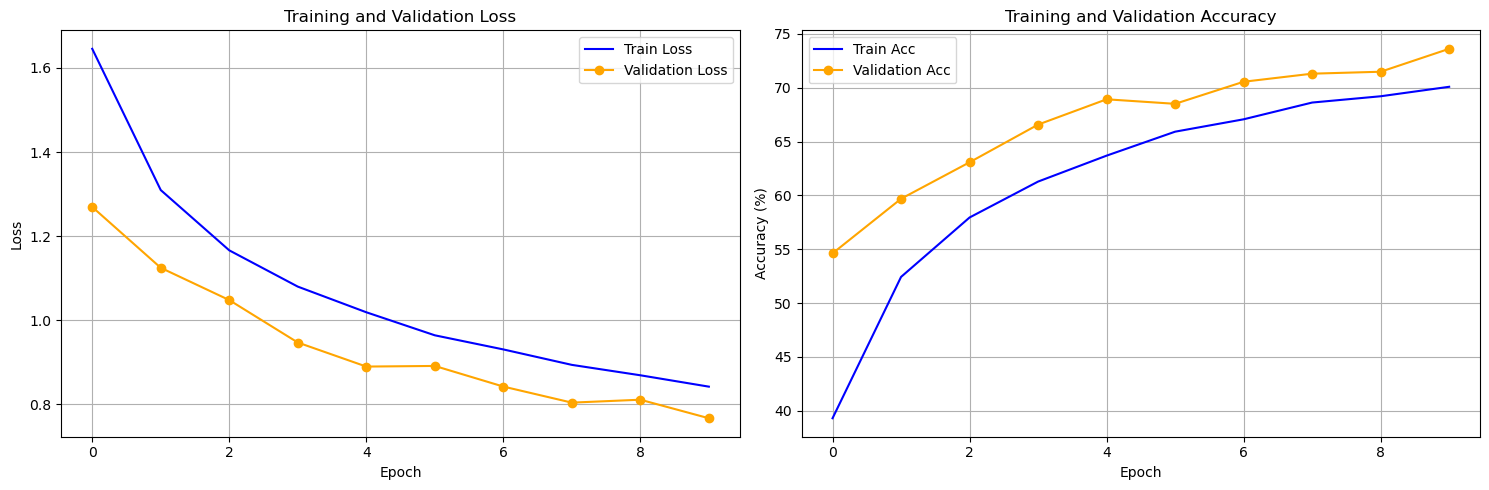

In [35]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
import copy
# Set device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using {device} device")

# Move model to device
net = net.to(device)
criterion = criterion.to(device)

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Number of epochs
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 60)
    
    # Training phase
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    batch_count = 0  # Counter for proper loss averaging
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        # Accumulate loss properly
        running_loss += loss.item()
        batch_count += 1
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print current batch loss instead of running average
        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')
    
    # Calculate training metrics properly
    train_acc = 100 * correct / total
    train_loss = running_loss / batch_count  # Average over all batches
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation phase
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_batch_count = 0  # Counter for validation batches
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_batch_count += 1
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate validation metrics properly
    val_acc = 100 * correct / total
    val_loss = val_loss / val_batch_count  # Average over all validation batches
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(net.state_dict())
    
    print(f'\nEpoch {epoch+1} Summary:')
    print(f'Training Loss: {train_loss:.3f}, Training Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.2f}%')

print('Finished Training')

# Load best model
net.load_state_dict(best_model_wts)

# Plot training curves with improved visualization
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Train Loss')
plt.plot(val_losses, 'orange', marker='o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, 'b-', label='Train Acc')
plt.plot(val_accs, 'orange', marker='o', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

Model accuracy on 10000 test images: 73.62%


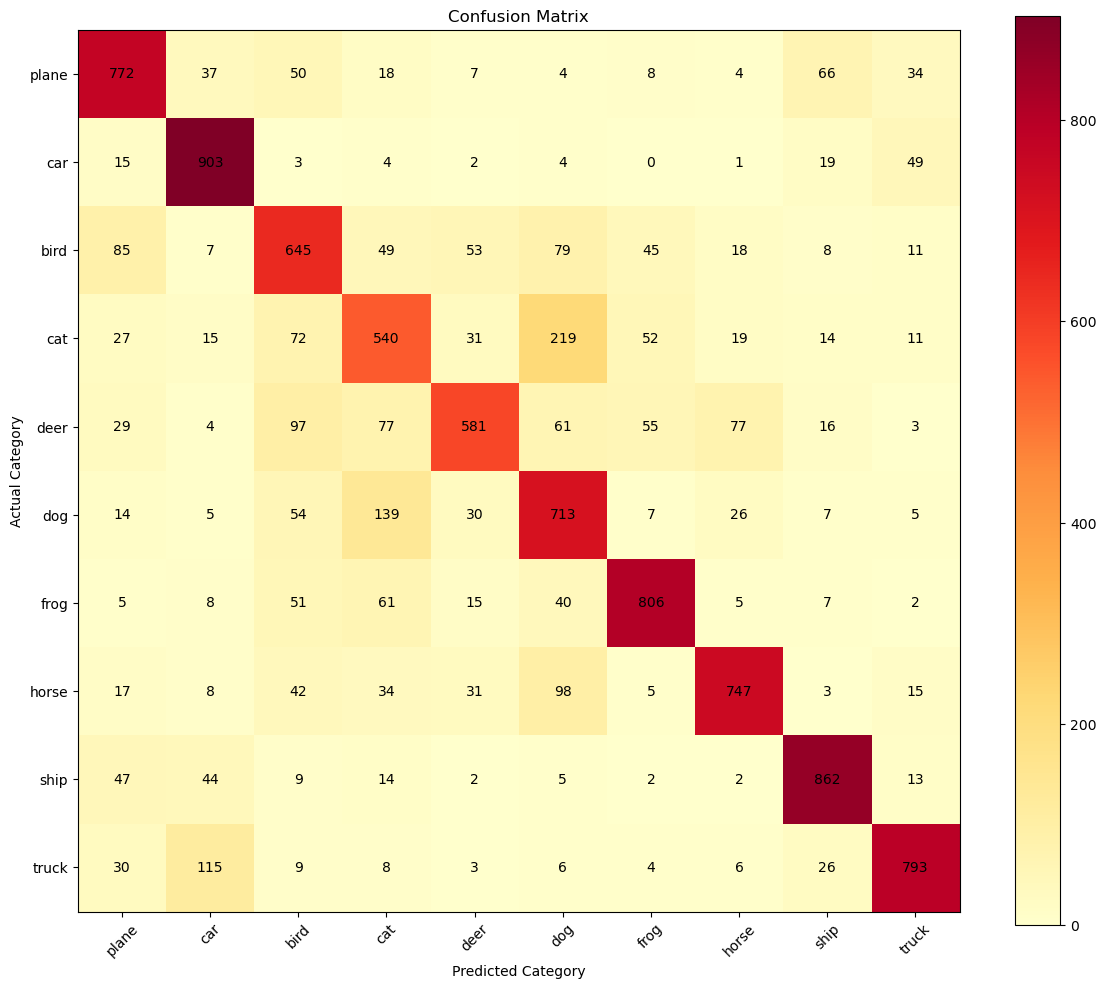

In [36]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
# Set model to evaluation mode
net.eval()

# Define CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Initialize counters
correct = 0
total = 0

# No gradients needed for evaluation
with torch.no_grad():
    for data in testloader:
        # Get images and labels and move to device (GPU)
        images, labels = data[0].to(device), data[1].to(device)
        
        # Forward pass
        outputs = net(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update confusion matrix - move tensors back to CPU for numpy operations
        for true_label, pred_label in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            confusion_matrix[true_label][pred_label] += 1

# Calculate final accuracy
model_accuracy = 100 * correct / total

# Create figure with larger size
plt.figure(figsize=(12, 10))

# Plot confusion matrix with numbers
im = plt.imshow(confusion_matrix, cmap='YlOrRd')  # Using YlOrRd colormap for yellow-to-red scale

# Add numbers to each cell
for i in range(10):
    for j in range(10):
        text = plt.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Add labels and title
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix')

# Set ticks and labels
plt.xticks(range(10), classes, rotation=45)
plt.yticks(range(10), classes)

# Add colorbar
plt.colorbar(im)

# Adjust layout to prevent label cutoff
plt.tight_layout()


#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

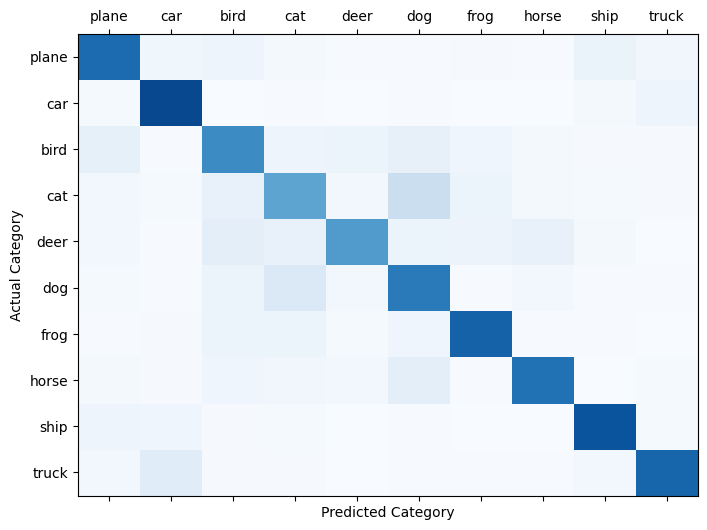

In [37]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** *During my experiments with CIFAR-10 classification, I found that a three-block CNN with increasing channels (32->64->128) provided the best results. Key factors in the model's success were using dropout (0.5) to prevent overfitting, batch normalization for training stability, and SGD optimization with carefully tuned parameters (lr=0.001, momentum=0.9, weight_decay=5e-4). I try adam optimizer but not works better.*

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** *The confusion matrix shows us where our model makes mistakes. The dark blue diagonal shows correct predictions, while lighter squares show errors - like mixing up cats with dogs and cars with trucks due to their similar appearance. Accuracy alone doesn't tell us these specific patterns of mistakes, which is why we need the confusion matrix to understand and improve our model's performance.*

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [79]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [80]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [81]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [82]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

<Figure size 1200x800 with 0 Axes>

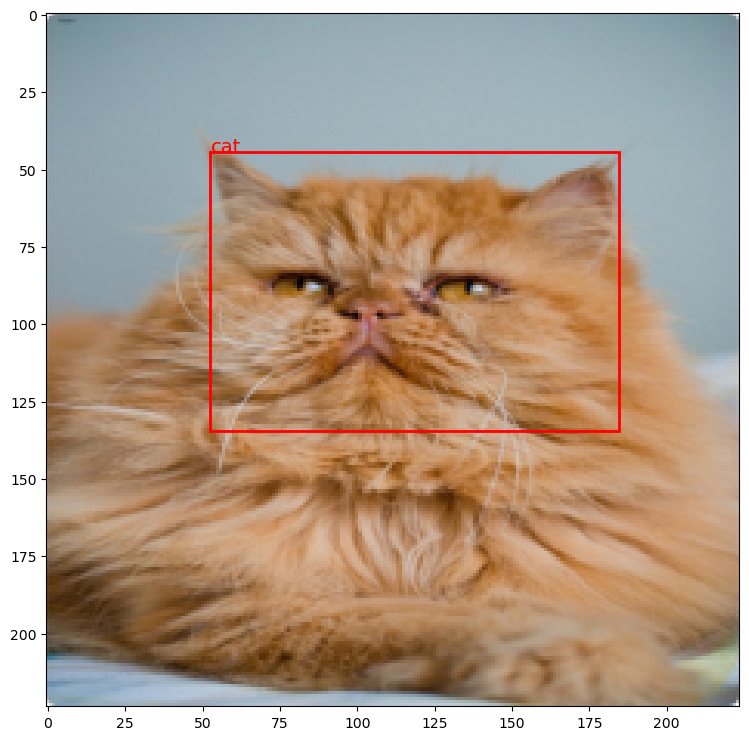

In [83]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [84]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################
        # Load pretrained ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=True)
        feature_size = self.backbone.fc.in_features  # 512 for ResNet18
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        
        # Classification model (separate head)
        self.classification_model = nn.Sequential(
            nn.Linear(feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
        # Detection model (separate head)
        self.detection_model = nn.Sequential(
            nn.Linear(feature_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4)  # bbox coordinates
        )
        
        # Freeze early layers of backbone
        ct = 0
        for child in self.backbone.children():
            ct += 1
            if ct < 1:  # Only freeze first conv layer
                for param in child.parameters():
                    param.requires_grad = False
      
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        # Get features from backbone
        features = self.backbone(images)
        features = features.view(features.size(0), -1)
        
        # Get predictions from both models
        class_scores = self.classification_model(features)
        bbox_coords = self.detection_model(features)
        
        return class_scores, bbox_coords
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [85]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
   since = time.time()
   best_model_wts = copy.deepcopy(model.state_dict())
   best_acc = 0.0

   # Track metrics 
   train_losses, val_losses = [], []
   train_accs, val_accs = [], []
   train_ious, val_ious = [], []


   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch+1, num_epochs))
       print('-' * 10)

       for phase in ['train', 'val']:
           if phase == 'train':
               model.train()
           else:
               model.eval()

           running_loss = 0.0
           running_corrects = 0 
           iou = 0.0
           
           for sample in dataloaders[phase]:
               #############################################################################
               # TO DO:                                                                    #
               # Extract the data from the dataloader, calculate the predictions of your   #
               # network and calculate the loss of the classification and bounding box     #
               # prediction. When in training mode, back-prop and update the weights.      #
               # At each epoch, calculate the test and train accuracy and IoU.             #
               # This function returns the best model in terms of accuracy.                #
               #############################################################################
               images = sample['image'].to(device)
               labels = sample['label'].to(device)
               bbox_targets = sample['bbox'].to(device)

               optimizer.zero_grad()

               with torch.set_grad_enabled(phase == 'train'):
                   # Forward pass
                   class_scores, bbox_pred = model(images)
                   _, preds = torch.max(class_scores, 1)
                   
                   # Loss calculation  
                   loss_cls = criterion_cls(class_scores, labels)
                   loss_bbox = criterion_bbox(bbox_pred, bbox_targets)
                   total_loss = loss_cls + 15 * loss_bbox
                   
                   if phase == 'train':
                       total_loss.backward()
                       optimizer.step()

               # Update metrics
               batch_size = images.size(0)
               running_loss += total_loss.item() * batch_size 
               running_corrects += (preds == labels.data).sum()

               # Calculate IoU using the helper function    
               batch_ious = [bb_intersection_over_union(pred, target)
                           for pred, target in zip(bbox_pred, bbox_targets)]
               iou += sum(batch_ious)
               #############################################################################
               #                             END OF YOUR CODE                              #
               #############################################################################

           epoch_loss = running_loss / dataset_sizes[phase]
           epoch_acc = running_corrects.float() / dataset_sizes[phase] 
           iou = iou / dataset_sizes[phase]
           
           print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
               phase, epoch_loss, epoch_acc, iou))
  
           # Store metrics for plotting
           if phase == 'train':
               train_losses.append(epoch_loss)
               train_accs.append(epoch_acc.item()) 
               train_ious.append(iou)
           else:
               val_losses.append(epoch_loss)
               val_accs.append(epoch_acc.item()) 
               val_ious.append(iou)
               
           if phase == 'val' and epoch_acc > best_acc:
               best_acc = epoch_acc
               best_model_wts = copy.deepcopy(model.state_dict())

   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))
   print('Best val Acc: {:4f}'.format(best_acc))

   model.load_state_dict(best_model_wts)
   return model, (train_losses, val_losses, train_accs, val_accs, train_ious, val_ious)

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [86]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss()
criterion_bbox = nn.SmoothL1Loss(beta=0.03)
optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-4)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Using device: cuda:0


In [87]:
best_model, metrics = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10 )

Epoch 1/10
----------
train Loss: 3.3637  |  Acc: 0.8664  |  IOU: 0.6193
val Loss: 2.9588  |  Acc: 0.7722  |  IOU: 0.6745
Epoch 2/10
----------
train Loss: 1.2505  |  Acc: 0.9638  |  IOU: 0.7837
val Loss: 1.2591  |  Acc: 0.9114  |  IOU: 0.7945
Epoch 3/10
----------
train Loss: 0.9719  |  Acc: 0.9654  |  IOU: 0.8226
val Loss: 1.3796  |  Acc: 0.9177  |  IOU: 0.7686
Epoch 4/10
----------
train Loss: 0.9249  |  Acc: 0.9591  |  IOU: 0.8297
val Loss: 0.9063  |  Acc: 0.9304  |  IOU: 0.8489
Epoch 5/10
----------
train Loss: 0.6530  |  Acc: 0.9937  |  IOU: 0.8594
val Loss: 0.7583  |  Acc: 0.9494  |  IOU: 0.8640
Epoch 6/10
----------
train Loss: 0.5821  |  Acc: 0.9921  |  IOU: 0.8706
val Loss: 1.0900  |  Acc: 0.8987  |  IOU: 0.8499
Epoch 7/10
----------
train Loss: 0.5569  |  Acc: 0.9874  |  IOU: 0.8775
val Loss: 0.8189  |  Acc: 0.9494  |  IOU: 0.8711
Epoch 8/10
----------
train Loss: 0.5538  |  Acc: 0.9780  |  IOU: 0.8828
val Loss: 0.8536  |  Acc: 0.9051  |  IOU: 0.8624
Epoch 9/10
----------
tr

<Figure size 1200x800 with 0 Axes>

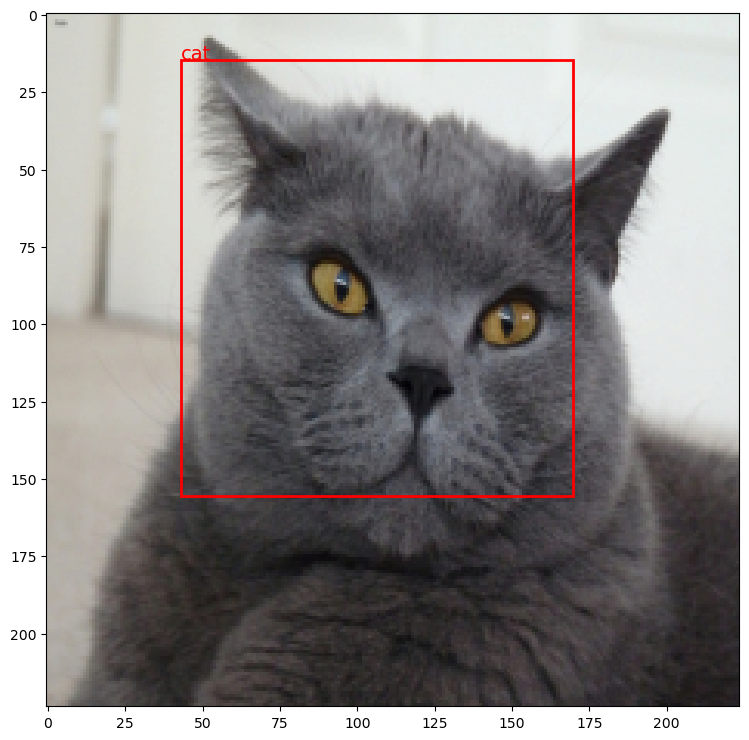

In [100]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

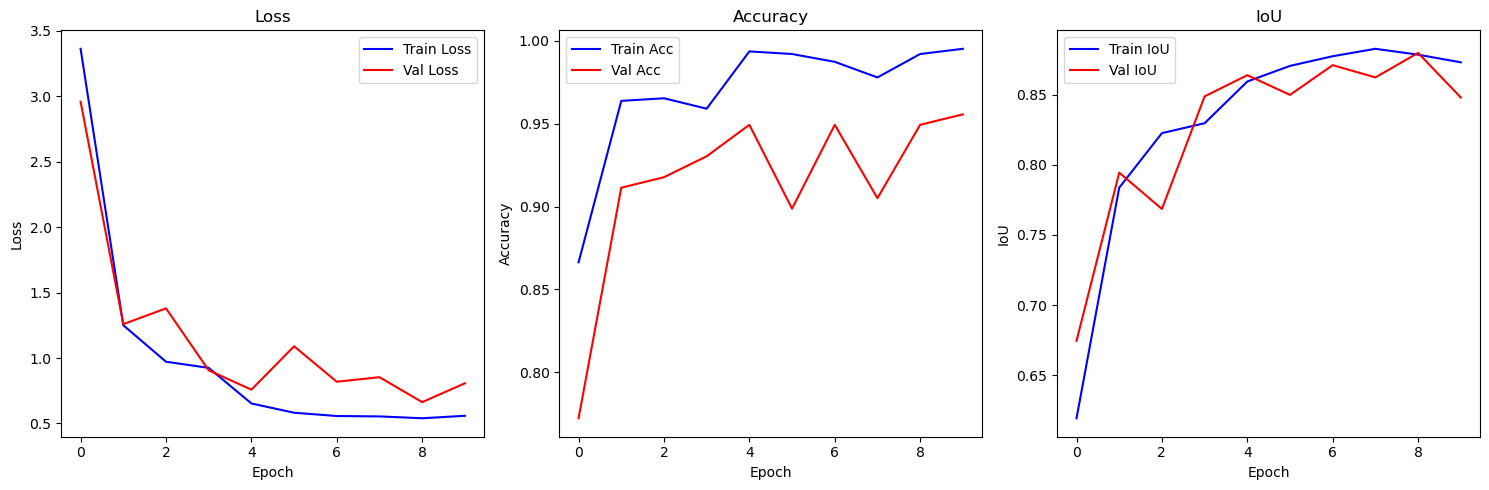

In [89]:
import matplotlib.pyplot as plt

# Convert tensors to NumPy arrays
train_iou = [x.cpu().detach().numpy() for x in metrics[4]]
val_iou = [x.cpu().detach().numpy() for x in metrics[5]]

plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(metrics[0], 'b-', label='Train Loss')
plt.plot(metrics[1], 'r-', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(metrics[2], 'b-', label='Train Acc')
plt.plot(metrics[3], 'r-', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# IoU Plot
plt.subplot(1, 3, 3)
plt.plot(train_iou, 'b-', label='Train IoU')
plt.plot(val_iou, 'r-', label='Val IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


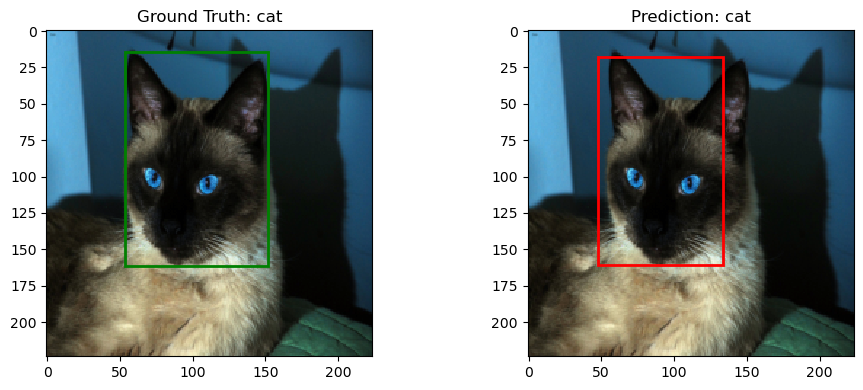

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


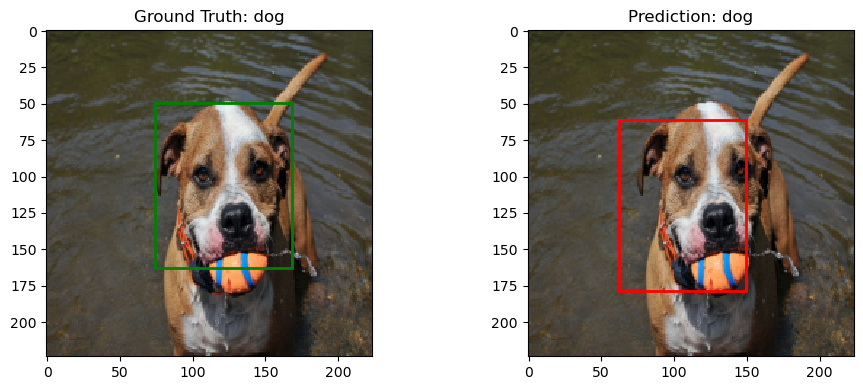

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


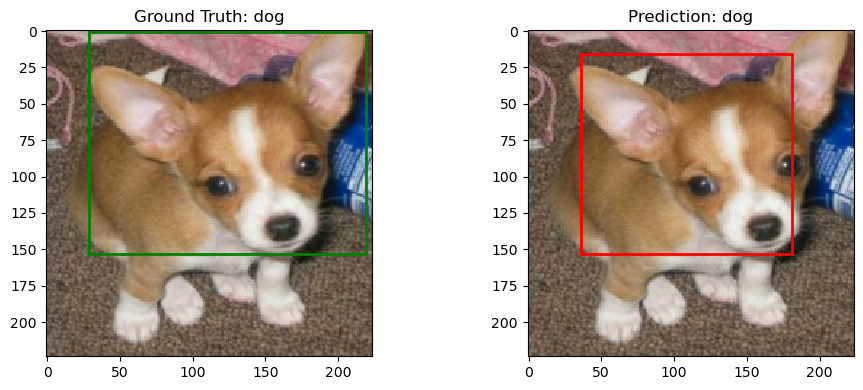

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


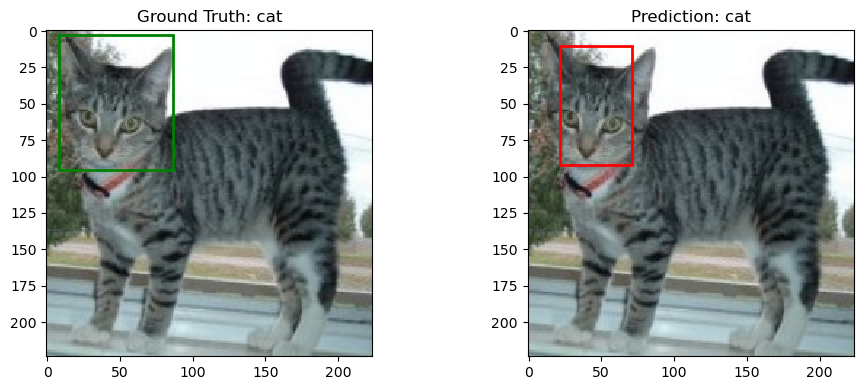

In [104]:
def visualize_bbox_predictions():
    # Get a batch of validation data
    sample = next(iter(dataloaders['val']))
    
    with torch.no_grad():
        # Get predictions
        images = sample['image'].to(device)
        gt_labels = sample['label']
        gt_bbox = sample['bbox']
        
        # Get model predictions
        label_pred, bbox_pred = cnn(images)
        _, predicted_labels = torch.max(label_pred, 1)
        
        # Move to CPU for visualization
        bbox_pred = bbox_pred.cpu()
        predicted_labels = predicted_labels.cpu()
        
        # Visualize first few samples
        for i in range(min(4, len(images))):
            plt.figure(figsize=(10, 4))
            
            # Plot ground truth
            plt.subplot(1, 2, 1)
            img = sample['image'][i].numpy().transpose(1, 2, 0)
            img = img * np.array([0.229, 0.224, 0.225])
            img += np.array([0.485, 0.456, 0.406])
            plt.imshow(img)
            
            # Draw ground truth bbox
            x1, y1, x2, y2 = gt_bbox[i].numpy() * 224  # Scale to image size
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                  linewidth=2, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)
            plt.title(f'Ground Truth: {classes[gt_labels[i]]}')
            
            # Plot prediction
            plt.subplot(1, 2, 2)
            plt.imshow(img)
            
            # Draw predicted bbox
            x1, y1, x2, y2 = bbox_pred[i].numpy() * 224  # Scale to image size
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                  linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.title(f'Prediction: {classes[predicted_labels[i]]}')
            
            plt.tight_layout()
            plt.show()

# Run visualization
visualize_bbox_predictions()



In [91]:
def evaluate_model(model, dataloaders, criterion_cls, criterion_bbox, dataset_sizes):
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    running_corrects = 0
    iou = 0.0

    for sample in dataloaders['val']:
        images = sample['image'].to(device)
        labels = sample['label'].to(device)
        bbox_targets = sample['bbox'].to(device)

        with torch.no_grad():
            # Forward pass
            class_scores, bbox_pred = model(images)
            _, preds = torch.max(class_scores, 1)

            # Loss calculation
            loss_cls = criterion_cls(class_scores, labels)
            loss_bbox = criterion_bbox(bbox_pred, bbox_targets)
            total_loss = loss_cls + 15 * loss_bbox  # more weight to bbox loss

        # Update metrics
        batch_size = images.size(0)
        running_loss += total_loss.item() * batch_size
        running_corrects += (preds == labels.data).sum()

        # Calculate IoU for each batch using helper function
        batch_ious = [bb_intersection_over_union(pred, target)
                      for pred, target in zip(bbox_pred, bbox_targets)]
        iou += sum(batch_ious)

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    iou = iou.item() / dataset_sizes['val']

    print('Validation Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
        epoch_loss, epoch_acc, iou))

# Evaluate the best model
evaluate_model(best_model, dataloaders, criterion_cls, criterion_bbox, dataset_sizes)

Validation Loss: 0.8070  |  Acc: 0.9557  |  IOU: 0.8481
